# mobile netv2 + Random Forest

In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
# mobilenetv2_random_forest.py
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

c:\Users\shoai\anaconda3\envs\aivenv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
# -------------------------
# Parameters
# -------------------------
dataset_path = 'potato'              # root folder with subfolders per class
img_size = (224, 224)
test_size = 0.2
random_state = 42
rf_n_estimators = 200               # good default; you can tune later
rf_n_jobs = -1                      # use all cores for speed
save_model_path = 'rf_model_mobilenetv2_potato.joblib'
save_le_path = 'label_encoder_mobilenetv2_potato.joblib'
report_csv = 'classification_report_rf.csv'

In [4]:


# -------------------------
# Load MobileNetV2 (feature extractor)
# -------------------------
print("Loading MobileNetV2 (pretrained, no top)...")
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg',
                             input_shape=(img_size[0], img_size[1], 3))
mobilenet_model.trainable = False   # freeze weights

Loading MobileNetV2 (pretrained, no top)...


In [5]:
# -------------------------
# Feature extraction helper
# -------------------------
def extract_features_mobilenetv2(image_path):
    """Load image, preprocess, and return flattened MobileNetV2 pooled features."""
    try:
        img = Image.open(image_path).convert('RGB').resize(img_size)
        arr = img_to_array(img)
        arr = preprocess_input(arr)
        arr = np.expand_dims(arr, axis=0)   # batch dimension
        features = mobilenet_model.predict(arr, verbose=0)
        return features.flatten()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [6]:
# -------------------------
# Load dataset and extract features
# -------------------------
features = []
labels = []

print("🔍 Extracting features from dataset...")
if not os.path.isdir(dataset_path):
    raise ValueError(f"Dataset path not found: {dataset_path}")

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    for img_file in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
        img_path = os.path.join(class_dir, img_file)
        fv = extract_features_mobilenetv2(img_path)
        if fv is not None:
            features.append(fv)
            labels.append(class_name)

features = np.array(features)
labels = np.array(labels)
print(f"Extracted features: {features.shape}, labels: {labels.shape}")

🔍 Extracting features from dataset...


Processing Potato___Late_blight: 100%|██████████| 1000/1000 [02:19<00:00,  7.14it/s]

Extracted features: (2152, 1280), labels: (2152,)


In [7]:
# -------------------------
# Encode labels and split
# -------------------------
le = LabelEncoder()
y = le.fit_transform(labels)
X = features

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# -------------------------
# Train Random Forest
# -------------------------
print("🧠 Training Random Forest classifier...")
rf = RandomForestClassifier(
    n_estimators=rf_n_estimators,
    random_state=random_state,
    n_jobs=rf_n_jobs,
    class_weight='balanced_subsample'  # helps if classes are imbalanced
)

rf.fit(X_train, y_train)

Train shape: (1721, 1280), Test shape: (431, 1280)
🧠 Training Random Forest classifier...


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



✅ Accuracy: 95.59%
📊 Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.98      0.98      0.98       200
 Potato___Late_blight       0.93      0.98      0.95       200
     Potato___healthy       1.00      0.61      0.76        31

             accuracy                           0.96       431
            macro avg       0.97      0.86      0.90       431
         weighted avg       0.96      0.96      0.95       431



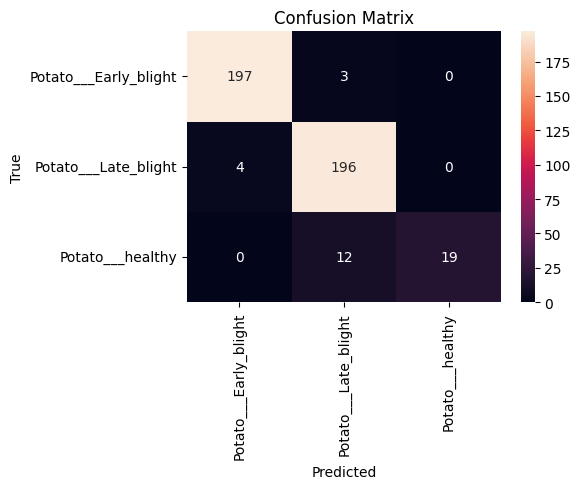

In [8]:
# -------------------------
# Evaluate
# -------------------------
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc * 100:.2f}%")
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot (nice for course slides)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [9]:

# Save classification report as CSV for handouts
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(2)
df_report.to_csv(report_csv)

In [10]:
# -------------------------
# Save model and label encoder
# -------------------------
joblib.dump(rf, save_model_path)
joblib.dump(le, save_le_path)
print(f"\n💾 Saved RandomForest model to {save_model_path} and LabelEncoder to {save_le_path}")


💾 Saved RandomForest model to rf_model_mobilenetv2_potato.joblib and LabelEncoder to label_encoder_mobilenetv2_potato.joblib



🖼️ Predicted Class for test image: Potato___Late_blight
Probabilities: {np.str_('Potato___Early_blight'): 0.275, np.str_('Potato___Late_blight'): 0.7, np.str_('Potato___healthy'): 0.025}


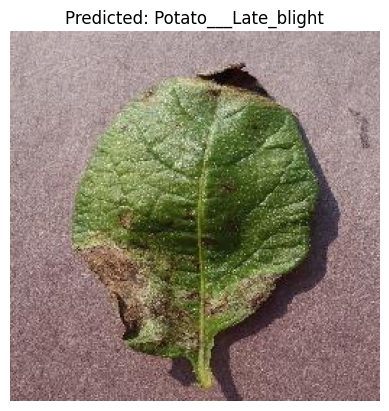

In [11]:
# -------------------------
# Inference example (use the same extraction function)
# -------------------------
test_image_path = r"C:\Users\shoai\Downloads\Machine Learning Projects\Real-World-Projects-ML+DL+Logic\Potato-Disease-Classifier\potato\Potato___Late_blight\00b1f292-23dd-44d4-aad3-c1ffb6a6ad5a___RS_LB 4479.JPG"
test_fv = extract_features_mobilenetv2(test_image_path)
if test_fv is not None:
    pred_label = rf.predict(test_fv.reshape(1, -1))[0]
    pred_proba = rf.predict_proba(test_fv.reshape(1, -1))[0]
    pred_class = le.inverse_transform([pred_label])[0]
    print(f"\n🖼️ Predicted Class for test image: {pred_class}")
    print("Probabilities:", {cls: float(prob) for cls, prob in zip(le.classes_, pred_proba)})

    # Show
    img = Image.open(test_image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {pred_class}")
    plt.axis('off')
    plt.show()
else:
    print("Test image processing failed.")
